## 3. Building and Training the Model

Setting up necessary libraries and loading the dataset for analysis.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('DATA/AMES_Final_DF.csv')

In [3]:
df.head()

,Unnamed: 0,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,0,141.0,31770,6,5,1960,1960,112.0,639.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,1,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,0,1,0,0,0,1,0
2,2,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,3,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,4,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,0,1,0,0,0,1,0


Separating features (`X`) from the target variable (`y`).


In [6]:
X = df.drop('SalePrice',axis=1)

In [9]:
df.shape

(2925, 275)

In [10]:
y = df['SalePrice']

Creating a train-eval split to initially explore linear regression on the dataset.


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=101)

We create a train-eval split to initially explore linear regression on the dataset.

In [13]:
X_temp_train, X_temp_eval, y_temp_train, y_temp_eval = train_test_split(X_train,y_train, test_size=0.25, random_state=101)

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
model = LinearRegression()

In [16]:
model.fit(X_temp_train,y_temp_train)

LinearRegression()

In [17]:
test_predictions = model.predict(X_temp_eval)

In [18]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [19]:
MSE = mean_squared_error(y_temp_eval,test_predictions)

In [20]:
RMSE = np.sqrt(MSE)

In [21]:
RMSE

22587.454264876465

we then plot the residuals to evaluate the fit of our linear regression model.

In [22]:
test_res = y_temp_eval - test_predictions

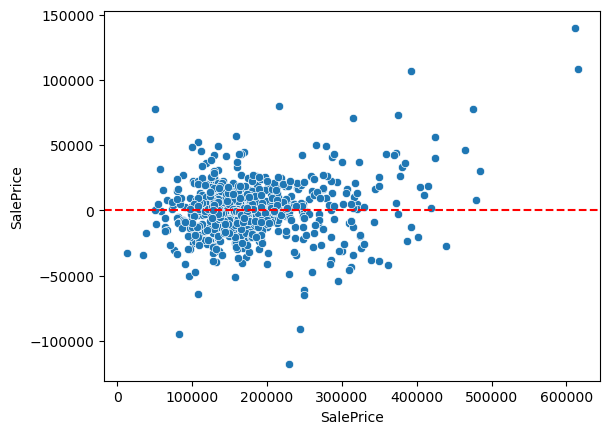

In [23]:
sns.scatterplot(x=y_temp_eval,y=test_res)
plt.axhline(y=0, color='r', linestyle='--')

As the residul plot has a bit of fanning occuring we will test polynomial regression to assess if increased complexity improves model performance.

In [20]:
from sklearn.preprocessing import PolynomialFeatures
degrees = range(1, 3)  
train_rmse_errors = []
test_rmse_errors = []

for degree in degrees:

    polynomial_converter = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = polynomial_converter.fit_transform(X_train)
    
    X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(poly_features, y_train, test_size=0.3, random_state=101)
    
 
    model = LinearRegression(fit_intercept=True)
    model.fit(X_poly_train, y_poly_train)
    
    train_pred = model.predict(X_poly_train)
    test_pred = model.predict(X_poly_test)
    
    train_RMSE = np.sqrt(mean_squared_error(y_poly_train, train_pred))
    test_RMSE = np.sqrt(mean_squared_error(y_poly_test, test_pred))
    
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)

In [31]:
train_rmse_errors

[19305.767767806203, 0.0005343277913433562]

In [32]:
test_rmse_errors

[21943.17816106492, 647854.6302507609]

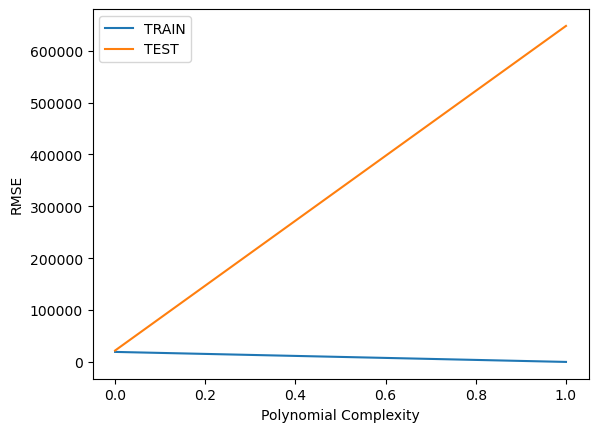

In [33]:
plt.plot(train_rmse_errors,label='TRAIN')
plt.plot(test_rmse_errors,label='TEST')
plt.xlabel("Polynomial Complexity")
plt.ylabel("RMSE")
plt.legend()

**Note:** The polynomial model shows overfitting, likely due to high feature dimensionality. We will continue with linear regression.

In [34]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=101)

Applying standard scaling to improve model performance.

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()

In [37]:
scaler.fit(X_train)

StandardScaler()

In [38]:
X_train = scaler.transform(X_train)

In [39]:
X_test = scaler.transform(X_test)

We will use ElasticNet regression with grid search to find optimal hyperparameters to improve bias and reduce overfitting

In [40]:
from sklearn.linear_model import ElasticNet

In [41]:
base_elastic_model = ElasticNet(max_iter=5000)

In [42]:
param_grid = {'alpha': np.logspace(-4, 2, 8),
              'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
# verbose number a personal preference
grid_model = GridSearchCV(estimator=base_elastic_model,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1)

In [ ]:
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


C:\Users\luke6\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.556e+11, tolerance: 1.355e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\luke6\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.640e+11, tolerance: 1.308e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\luke6\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.132e+11, toleranc

In [35]:
grid_model.best_estimator_

ElasticNet(alpha=100.0, l1_ratio=1)

In [36]:
grid_model.best_params_

{'alpha': 100.0, 'l1_ratio': 1}

We use the optimal hyperparameters from grid search to build and train the final ElasticNet model.

In [37]:
best_l1_ratio = 1

In [38]:
alpha_values  = np.linspace(1, 150, 8)

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
cv_scores = []
for alpha in alpha_values:
    model = ElasticNet(alpha=alpha, l1_ratio=best_l1_ratio, max_iter=100000)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    mean_rmse = np.sqrt(-scores.mean())  # Convert MSE to RMSE
    cv_scores.append((alpha, mean_rmse))
best_alpha, best_rmse = min(cv_scores, key=lambda x: x[1])

In [41]:
best_alpha

128.71428571428572

In [42]:
final_model = ElasticNet(alpha = 128.71428571428572
, l1_ratio=1,max_iter=10000)

In [43]:
final_model.fit(X_train,y_train)

ElasticNet(alpha=128.71428571428572, l1_ratio=1, max_iter=10000)

In [44]:
predictions =final_model.predict(X_test)

In [45]:
RMSE = np.sqrt(mean_squared_error(predictions,y_test))

In [46]:
RMSE

20560.663805938435

The final ElasticNet model achieved an RMSE of approximately `20560.663805938435`, indicating its effectiveness in predicting housing prices with regularization. Future improvements could include feature engineering or additional tuning for enhanced accuracy.


# Conclusion

This project  demonstrates the use of various regression models to predict housing prices based on extensive property data. By applying linear and polynomial regression techniques and experimenting with regularization, we gained valuable insights into the model's strengths and limitations for housing price prediction.

## Key Takeaways

- **Data Cleaning and Preparation**: Through careful handling of missing values, outliers, and categorical encoding, we ensured that our dataset was well-suited for regression analysis, minimizing the risk of biases or inaccuracies.
- **Linear Regression**: Our initial linear regression model provided a strong baseline, capturing significant trends without excessive overfitting.
- **Polynomial Regression**: While polynomial regression allowed for more flexibility, it showed signs of overfitting, especially given the high dimensionality of the dataset.
- **Regularization**: By implementing ElasticNet with hyperparameter tuning, we achieved a balanced model that prevented overfitting while maintaining good predictive accuracy. ElasticNet proved effective in managing complex data relationships without compromising the model's generalization capability.

## Future Directions

To further enhance model performance, we could explore additional feature engineering, advanced regularization techniques, or even ensemble methods. Additionally, incorporating external data, such as economic or neighborhood trends, could provide more contextual insights into housing price fluctuations.
